In [2]:
print('hello')

hello



🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤
      EMNIST DATASET LOADER & CONVERTER
🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤🔤

📖 EMNIST Info:
   - EMNIST adalah Extended MNIST
   - Berisi: angka (0-9), huruf (A-Z, a-z)
   - Format: 28x28 grayscale
   - Total: 800,000+ samples

📦 Dataset Variants:
   1. balanced  : 47 classes, balanced (RECOMMENDED)
   2. byclass   : 62 classes, full (0-9, A-Z, a-z)
   3. digits    : 10 classes (0-9)
   4. letters   : 26 classes (A-Z)

🚀 QUICK START - EMNIST dari CSV (Kaggle)

📌 IMPORTANT: Ganti path di baris 265-266 dengan path file CSV kamu!
   Current train path: emnist/emnist-balanced-train.csv
   Current test path: emnist/emnist-balanced-test.csv

Tekan Enter untuk lanjut (atau Ctrl+C untuk edit path dulu)...


📂 Loading EMNIST from CSV...
   Train: emnist/emnist-balanced-train.csv
   ✅ Loaded 112,799 training samples
   Test: emnist/emnist-balanced-test.csv
   ✅ Loaded 18,799 test samples

   📊 Classes: 47
   📊 Label range: 0 - 46

   🔤 Class mapping created: 47 classes

📊 Class Distribution:
--------------------------------------------------
     0 ( 0):  2,400 ██████████████████████████████
     1 ( 1):  2,400 ██████████████████████████████
     2 ( 2):  2,400 ██████████████████████████████
     3 ( 3):  2,400 ██████████████████████████████
     4 ( 4):  2,400 ██████████████████████████████
     5 ( 5):  2,400 ██████████████████████████████
     6 ( 6):  2,400 ██████████████████████████████
     7 ( 7):  2,400 ██████████████████████████████
     8 ( 8):  2,400 ██████████████████████████████
     9 ( 9):  2,400 ██████████████████████████████
     A (10):  2,400 ██████████████████████████████
     B (11):  2,400 ██████████████████████████████
     C (12):  2,400 █████████████████████████████

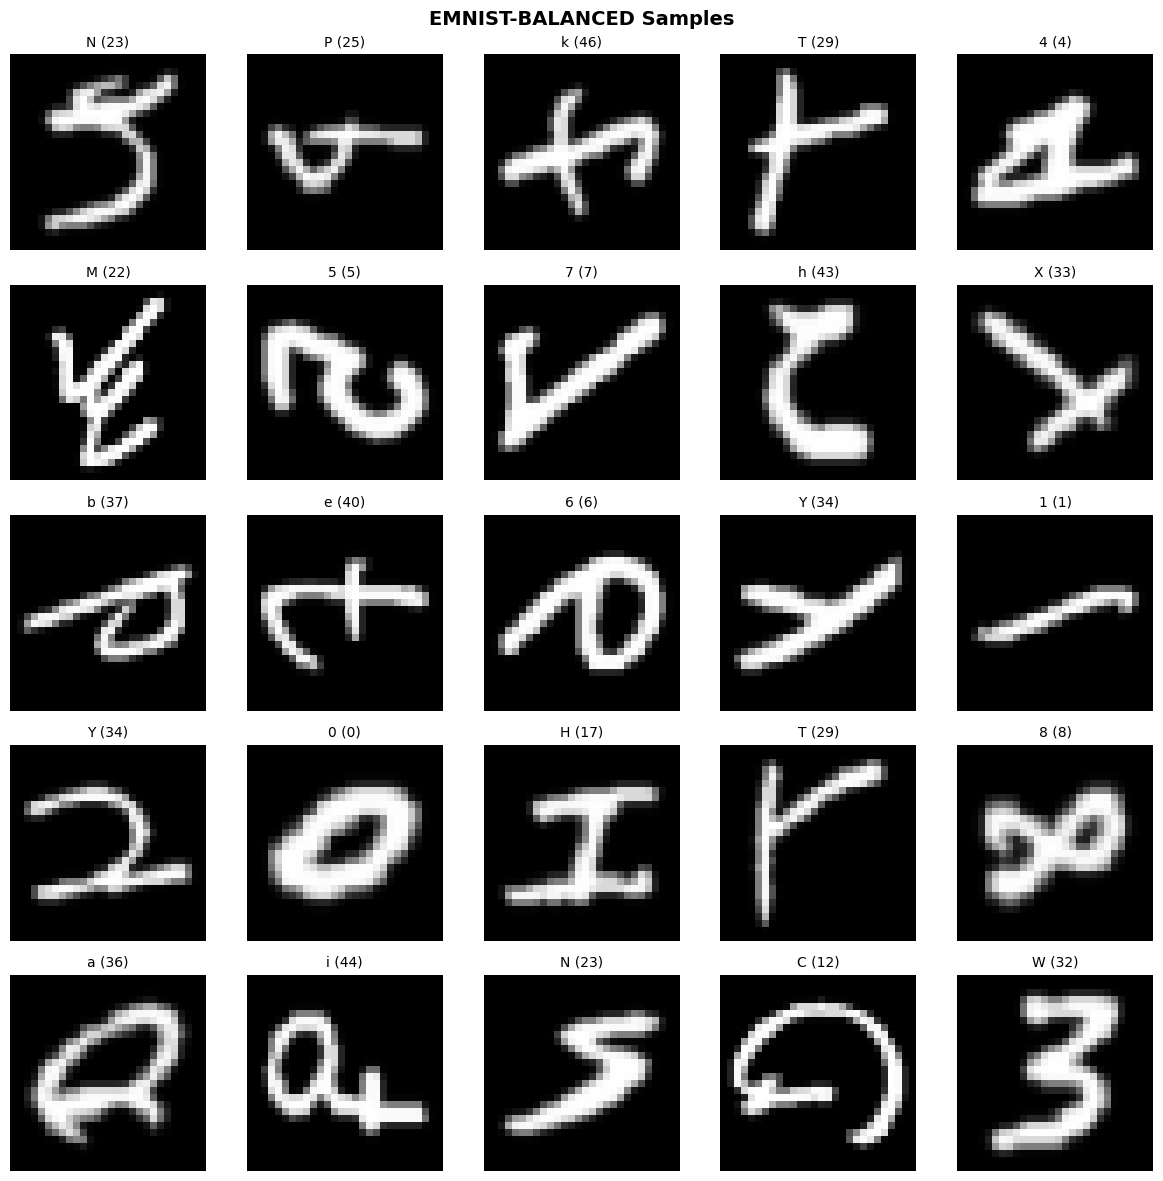


⚙️  Preparing data for CNN...
   ✅ Normalized to [0, 1]
   ✅ One-hot encoded (47 classes)

   📊 Training set: (112799, 28, 28, 1)
   📊 Test set: (18799, 28, 28, 1)

✅ Data ready for CNN training!
   Use: model.fit(X_train_cnn, y_train_cnn, ...)

✅ EMNIST loaded successfully!

💡 Next steps:
   1. Combine dengan Math Symbols dataset
   2. Train CNN model
   3. Integrate dengan segmentation kamu


In [1]:
"""
EMNIST Dataset Loader & Converter
Supports:
1. Load dari CSV (Kaggle format)
2. Load dari binary .gz (Original format)
3. Convert to images
4. Visualize samples
5. Prepare for CNN training
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.utils import to_categorical
import gzip
import struct

class EMNISTLoader:
    def __init__(self, dataset_type='balanced'):
        """
        dataset_type: 'balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist'
        
        EMNIST Variants:
        - balanced: 47 classes (digits + letters, balanced)
        - byclass: 62 classes (0-9, A-Z, a-z)
        - bymerge: 47 classes (merged similar chars)
        - digits: 10 classes (0-9)
        - letters: 26 classes (A-Z)
        """
        self.dataset_type = dataset_type
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.class_mapping = None
        
    def load_from_csv(self, train_path, test_path=None):
        """
        Load EMNIST dari CSV (Kaggle format)
        
        CSV Format:
        label, pixel_0, pixel_1, ..., pixel_783
        """
        print(f"📂 Loading EMNIST from CSV...")
        print(f"   Train: {train_path}")
        
        # Load training data
        df_train = pd.read_csv(train_path)
        print(f"   ✅ Loaded {len(df_train):,} training samples")
        
        # Extract labels and pixels
        self.y_train = df_train.iloc[:, 0].values
        self.X_train = df_train.iloc[:, 1:].values
        
        # Reshape to 28x28
        self.X_train = self.X_train.reshape(-1, 28, 28)
        
        # Load test data if provided
        if test_path:
            print(f"   Test: {test_path}")
            df_test = pd.read_csv(test_path)
            print(f"   ✅ Loaded {len(df_test):,} test samples")
            
            self.y_test = df_test.iloc[:, 0].values
            self.X_test = df_test.iloc[:, 1:].values
            self.X_test = self.X_test.reshape(-1, 28, 28)
        
        # Get class info
        unique_labels = np.unique(self.y_train)
        print(f"\n   📊 Classes: {len(unique_labels)}")
        print(f"   📊 Label range: {unique_labels.min()} - {unique_labels.max()}")
        
        # Create mapping
        self.create_class_mapping()
        
        return self.X_train, self.y_train, self.X_test, self.y_test
    
    def load_from_binary(self, images_path, labels_path):
        """
        Load EMNIST dari binary .gz format (Original MNIST format)
        """
        print(f"📂 Loading EMNIST from binary...")
        
        # Load images
        with gzip.open(images_path, 'rb') as f:
            magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
            images = np.frombuffer(f.read(), dtype=np.uint8)
            images = images.reshape(num, rows, cols)
        
        # Load labels
        with gzip.open(labels_path, 'rb') as f:
            magic, num = struct.unpack('>II', f.read(8))
            labels = np.frombuffer(f.read(), dtype=np.uint8)
        
        print(f"   ✅ Loaded {num:,} samples")
        
        return images, labels
    
    def create_class_mapping(self):
        """
        Create mapping from label number to character
        """
        if self.dataset_type == 'balanced' or self.dataset_type == 'bymerge':
            # 47 classes: 0-9, A-Z, a-z (some merged)
            mapping = {}
            # Digits 0-9
            for i in range(10):
                mapping[i] = str(i)
            # Uppercase A-Z
            for i in range(26):
                mapping[i + 10] = chr(65 + i)  # A=65 in ASCII
            # Lowercase a-z (some might be merged)
            for i in range(11):  # Only 11 lowercase in balanced
                mapping[i + 36] = chr(97 + i)  # a=97 in ASCII
                
        elif self.dataset_type == 'byclass':
            # 62 classes: 0-9, A-Z, a-z
            mapping = {}
            for i in range(10):
                mapping[i] = str(i)
            for i in range(26):
                mapping[i + 10] = chr(65 + i)
            for i in range(26):
                mapping[i + 36] = chr(97 + i)
                
        elif self.dataset_type == 'digits':
            # 10 classes: 0-9
            mapping = {i: str(i) for i in range(10)}
            
        elif self.dataset_type == 'letters':
            # 26 classes: A-Z
            mapping = {i: chr(65 + i) for i in range(26)}
        
        self.class_mapping = mapping
        print(f"\n   🔤 Class mapping created: {len(mapping)} classes")
        
        return mapping
    
    def get_char_from_label(self, label):
        """Convert numeric label to character"""
        if self.class_mapping:
            return self.class_mapping.get(label, '?')
        return str(label)
    
    def visualize_samples(self, num_samples=25, random_state=42):
        """Visualize random samples from dataset"""
        if self.X_train is None:
            print("❌ Dataset belum di-load!")
            return
        
        np.random.seed(random_state)
        indices = np.random.choice(len(self.X_train), num_samples, replace=False)
        
        rows = int(np.sqrt(num_samples))
        cols = int(np.ceil(num_samples / rows))
        
        fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
        axes = axes.flatten()
        
        for i, idx in enumerate(indices):
            img = self.X_train[idx]
            label = self.y_train[idx]
            char = self.get_char_from_label(label)
            
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f'{char} ({label})', fontsize=10)
            axes[i].axis('off')
        
        # Hide extra subplots
        for i in range(num_samples, len(axes)):
            axes[i].axis('off')
        
        plt.suptitle(f'EMNIST-{self.dataset_type.upper()} Samples', 
                     fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    def save_as_images(self, output_dir, max_per_class=100):
        """
        Save dataset as PNG images
        
        Structure:
        output_dir/
            ├── train/
            │   ├── 0/
            │   │   ├── img_0000.png
            │   │   ├── img_0001.png
            │   ├── 1/
            │   ├── A/
            │   └── ...
            └── test/
                └── ...
        """
        print(f"\n💾 Saving images to: {output_dir}/")
        
        for split_name, X, y in [('train', self.X_train, self.y_train),
                                  ('test', self.X_test, self.y_test)]:
            if X is None:
                continue
            
            split_dir = os.path.join(output_dir, split_name)
            os.makedirs(split_dir, exist_ok=True)
            
            # Group by class
            for label in np.unique(y):
                char = self.get_char_from_label(label)
                class_dir = os.path.join(split_dir, str(char))
                os.makedirs(class_dir, exist_ok=True)
                
                # Get samples for this class
                mask = y == label
                class_images = X[mask]
                
                # Limit number
                class_images = class_images[:max_per_class]
                
                # Save
                for i, img in enumerate(class_images):
                    filename = f'img_{i:04d}.png'
                    filepath = os.path.join(class_dir, filename)
                    cv2.imwrite(filepath, img)
                
                print(f"   ✅ {split_name}/{char}: {len(class_images)} images")
        
        print(f"\n✅ Done! Images saved to {output_dir}/")
    
    def prepare_for_cnn(self, normalize=True, categorical=True):
        """
        Prepare data for CNN training
        
        Returns:
            X_train, y_train, X_test, y_test (ready for model.fit)
        """
        print("\n⚙️  Preparing data for CNN...")
        
        # Reshape for CNN (add channel dimension)
        X_train = self.X_train.reshape(-1, 28, 28, 1)
        X_test = self.X_test.reshape(-1, 28, 28, 1) if self.X_test is not None else None
        
        # Normalize
        if normalize:
            X_train = X_train.astype('float32') / 255.0
            if X_test is not None:
                X_test = X_test.astype('float32') / 255.0
            print("   ✅ Normalized to [0, 1]")
        
        # One-hot encode labels
        y_train = self.y_train
        y_test = self.y_test
        
        if categorical:
            num_classes = len(np.unique(self.y_train))
            y_train = to_categorical(self.y_train, num_classes)
            if y_test is not None:
                y_test = to_categorical(self.y_test, num_classes)
            print(f"   ✅ One-hot encoded ({num_classes} classes)")
        
        print(f"\n   📊 Training set: {X_train.shape}")
        if X_test is not None:
            print(f"   📊 Test set: {X_test.shape}")
        
        return X_train, y_train, X_test, y_test
    
    def get_class_distribution(self):
        """Show class distribution"""
        if self.y_train is None:
            return
        
        unique, counts = np.unique(self.y_train, return_counts=True)
        
        print("\n📊 Class Distribution:")
        print("-" * 50)
        
        for label, count in zip(unique, counts):
            char = self.get_char_from_label(label)
            bar = '█' * int(count / counts.max() * 30)
            print(f"   {char:>3} ({label:2d}): {count:6,} {bar}")
        
        print("-" * 50)
        print(f"   Total: {len(self.y_train):,} samples")


# ==================== QUICK START GUIDE ====================
def quick_start_csv():
    """Quick start untuk CSV format (Kaggle)"""
    print("="*70)
    print("🚀 QUICK START - EMNIST dari CSV (Kaggle)")
    print("="*70)
    
    # Initialize
    loader = EMNISTLoader(dataset_type='balanced')
    
    # Load data
    # GANTI PATH INI dengan lokasi file CSV kamu!

    train_csv = 'emnist/emnist-balanced-train.csv'  # Tambahkan nama foldernya
    test_csv = 'emnist/emnist-balanced-test.csv'    # Tambahkan nama foldernya
    
    print("\n📌 IMPORTANT: Ganti path di baris 265-266 dengan path file CSV kamu!")
    print(f"   Current train path: {train_csv}")
    print(f"   Current test path: {test_csv}")
    print("\nTekan Enter untuk lanjut (atau Ctrl+C untuk edit path dulu)...")
    input()
    
    try:
        X_train, y_train, X_test, y_test = loader.load_from_csv(train_csv, test_csv)
        
        # Show distribution
        loader.get_class_distribution()
        
        # Visualize samples
        print("\n🎨 Visualizing random samples...")
        loader.visualize_samples(num_samples=25)
        
        # Prepare for CNN
        X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn = loader.prepare_for_cnn()
        
        print("\n✅ Data ready for CNN training!")
        print(f"   Use: model.fit(X_train_cnn, y_train_cnn, ...)")
        
        return loader, X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn
        
    except FileNotFoundError as e:
        print(f"\n❌ Error: File tidak ditemukan!")
        print(f"   {e}")
        print(f"\n💡 Download EMNIST dari:")
        print(f"   https://www.kaggle.com/datasets/crawford/emnist")
        return None


def example_save_images():
    """Example: Save dataset as images"""
    loader = EMNISTLoader(dataset_type='balanced')
    
    # Load
    loader.load_from_csv('emnist-balanced-train.csv', 'emnist-balanced-test.csv')
    
    # Save as images (max 100 per class)
    loader.save_as_images('emnist_images', max_per_class=100)


# ==================== MAIN ====================
if __name__ == "__main__":
    print("\n" + "🔤"*35)
    print("      EMNIST DATASET LOADER & CONVERTER")
    print("🔤"*35)
    
    print("\n📖 EMNIST Info:")
    print("   - EMNIST adalah Extended MNIST")
    print("   - Berisi: angka (0-9), huruf (A-Z, a-z)")
    print("   - Format: 28x28 grayscale")
    print("   - Total: 800,000+ samples")
    
    print("\n📦 Dataset Variants:")
    print("   1. balanced  : 47 classes, balanced (RECOMMENDED)")
    print("   2. byclass   : 62 classes, full (0-9, A-Z, a-z)")
    print("   3. digits    : 10 classes (0-9)")
    print("   4. letters   : 26 classes (A-Z)")
    
    print("\n" + "="*70)
    
    # Run quick start
    result = quick_start_csv()
    
    if result:
        print("\n✅ EMNIST loaded successfully!")
        print("\n💡 Next steps:")
        print("   1. Combine dengan Math Symbols dataset")
        print("   2. Train CNN model")
        print("   3. Integrate dengan segmentation kamu")


🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
      CNN TRAINING - EMNIST + MATH SYMBOLS
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯

📂 LOADING EMNIST DATASET
Loading: emnist/emnist-balanced-train.csv
   ✅ Train: 112,799 samples
Loading: emnist/emnist-balanced-test.csv
   ✅ Test:  18,799 samples

   📊 Total EMNIST: 131,598 samples

   Creating class mapping...
   ✅ EMNIST classes: 47

🔢 LOADING MATH SYMBOLS DATASET
Directory: C:/Users/LENOVO/tubesAILab/math/data/extracted_images

   Found 82 symbol classes:

   ✅ !               : 1300 images (label: 47)
   ✅ (               : 14294 images (label: 48)
   ✅ )               : 14355 images (label: 49)
   ✅ +               : 25112 images (label: 50)
   ✅ ,               : 1906 images (label: 51)
   ✅ -               : 33997 images (label: 52)
   ✅ 0               : 6914 images (label: 53)
   ✅ 1               : 26520 images (label: 54)
   ✅ 2               : 26141 images (label: 55)
   ✅ 3               : 10909 images (label: 56)
   ✅ 4               : 739

C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



📋 Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 129)                 │          33,153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 422,913 (1.61 MB)

 Trainable params: 421,953 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)


⚠️  Training will start in 5 seconds...
   Press Ctrl+C to cancel


🚀 TRAINING MODEL

   Epochs: 20
   Batch size: 128
   Training samples: 366,720
   Validation samples: 64,716

Epoch 1/20
2865/2865 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.6638 - loss: 1.3617
Epoch 1: val_accuracy improved from -inf to 0.89389, saving model to best_ocr_model.keras
2865/2865 ━━━━━━━━━━━━━━━━━━━━ 332s 113ms/step - accuracy: 0.6639 - loss: 1.3615 - val_accuracy: 0.8939 - val_loss: 0.3406 - learning_rate: 0.0010
Epoch 2/20
2865/2865 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8667 - loss: 0.4332
Epoch 2: val_accuracy improved from 0.89389 to 0.91427, saving model to best_ocr_model.keras
2865/2865 ━━━━━━━━━━━━━━━━━━━━ 311s 108ms/step - accuracy: 0.8667 - loss: 0.4332 - val_accuracy: 0.9143 - val_loss: 0.2686 - learning_rate: 0.0010
Epoch 3/20
2865/2865 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8850 - loss: 0.3692
Epoch 3: val_accuracy improved from 0.91427 to 0.92427, saving model to b

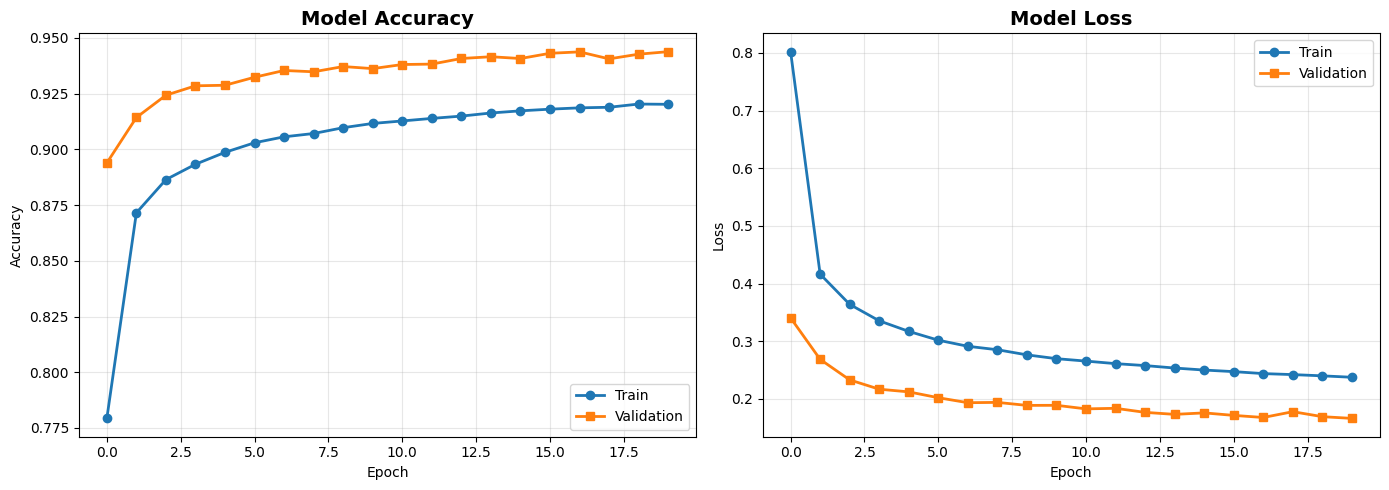


🧪 EVALUATING MODEL

   📊 Test Loss:     0.1649
   📊 Test Accuracy: 94.50%

💾 SAVING MODEL & METADATA

   ✅ Model saved: ocr_model.keras
   ✅ Mapping saved: class_mapping.json
   ✅ Metadata saved: model_metadata.json

✅ TRAINING COMPLETE!

📂 Output Files:
   ├── best_ocr_model.keras
   ├── ocr_model.keras
   ├── class_mapping.json
   ├── model_metadata.json
   └── training_history.png

🎯 Final Results:
   • Total Classes: 129
   • EMNIST: 47 classes
   • Math Symbols: 82 classes
   • Test Accuracy: 94.50%

   🏆 EXCELLENT! Model is production-ready!

💡 Next Steps:
   1. Test dengan tulisan tangan real
   2. Integrate dengan segmentation pipeline
   3. Build complete OCR system


In [3]:
"""
CNN Model Training - EMNIST + Math Symbols COMBINED
Complete pipeline dari load data sampai training
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import json
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# ==================== CONFIGURATION ====================
CONFIG = {
    # Dataset paths - EDIT THESE!
    'emnist_train': 'emnist/emnist-balanced-train.csv',
    'emnist_test': 'emnist/emnist-balanced-test.csv',
    'math_symbols_dir': 'extracted_images',  # Folder math symbols, atau None kalau skip
    'math_symbols_dir': 'C:/Users/LENOVO/tubesAILab/math/data/extracted_images',
    
    # Training params
    'epochs': 20,
    'batch_size': 128,
    'validation_split': 0.15,
    'test_split': 0.15,
    
    # Output files
    'model_save': 'ocr_model.keras',
    'best_model_save': 'best_ocr_model.keras',
    'mapping_save': 'class_mapping.json',
    'metadata_save': 'model_metadata.json'
}


# ==================== 1. DATASET COMBINER ====================
class DatasetCombiner:
    """Combine EMNIST + Math Symbols into unified dataset"""
    
    def __init__(self):
        self.X_all = []
        self.y_all = []
        self.class_mapping = {}
        self.num_classes = 0
        
    def load_emnist(self, train_csv, test_csv):
        """Load EMNIST from CSV"""
        print("\n" + "="*70)
        print("📂 LOADING EMNIST DATASET")
        print("="*70)
        
        # Load train
        print(f"Loading: {train_csv}")
        df_train = pd.read_csv(train_csv)
        y_train = df_train.iloc[:, 0].values
        X_train = df_train.iloc[:, 1:].values.reshape(-1, 28, 28)
        print(f"   ✅ Train: {len(X_train):,} samples")
        
        # Load test
        print(f"Loading: {test_csv}")
        df_test = pd.read_csv(test_csv)
        y_test = df_test.iloc[:, 0].values
        X_test = df_test.iloc[:, 1:].values.reshape(-1, 28, 28)
        print(f"   ✅ Test:  {len(X_test):,} samples")
        
        # Combine
        X = np.concatenate([X_train, X_test])
        y = np.concatenate([y_train, y_test])
        
        print(f"\n   📊 Total EMNIST: {len(X):,} samples")
        
        # Create mapping (EMNIST Balanced: 47 classes)
        print(f"\n   Creating class mapping...")
        
        # Digits 0-9
        for i in range(10):
            self.class_mapping[i] = str(i)
        
        # Uppercase A-Z
        for i in range(26):
            self.class_mapping[i + 10] = chr(65 + i)
        
        # Lowercase a-k (balanced version only has 11)
        for i in range(11):
            self.class_mapping[i + 36] = chr(97 + i)
        
        print(f"   ✅ EMNIST classes: {len(self.class_mapping)}")
        
        # Store
        self.X_all.append(X)
        self.y_all.append(y)
        self.num_classes = len(self.class_mapping)
        
        return len(X)
    
    def load_math_symbols(self, math_dir):
        """Load math symbols from directory"""
        
        if not math_dir or not os.path.exists(math_dir):
            print(f"\n⚠️  Math symbols directory not found: {math_dir}")
            print(f"   Skipping math symbols, using EMNIST only")
            return 0
        
        print("\n" + "="*70)
        print("🔢 LOADING MATH SYMBOLS DATASET")
        print("="*70)
        print(f"Directory: {math_dir}\n")
        
        math_X = []
        math_y = []
        
        base_label = self.num_classes
        
        # Get all subdirectories (each = one symbol class)
        folders = sorted([d for d in os.listdir(math_dir) 
                         if os.path.isdir(os.path.join(math_dir, d))])
        
        if not folders:
            print(f"   ⚠️  No symbol folders found, skipping")
            return 0
        
        print(f"   Found {len(folders)} symbol classes:\n")
        
        for folder in folders:
            folder_path = os.path.join(math_dir, folder)
            
            # Get all images
            images = [f for f in os.listdir(folder_path) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
            
            if not images:
                continue
            
            # Assign new label
            symbol_label = base_label
            self.class_mapping[symbol_label] = folder
            base_label += 1
            
            # Load images
            for img_file in images:
                img_path = os.path.join(folder_path, img_file)
                
                # Read as grayscale
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                if img is not None:
                    # Resize to 28x28
                    img = cv2.resize(img, (28, 28))
                    
                    # Invert if needed (ensure white text on black background → black on white)
                    if np.mean(img) > 127:
                        img = 255 - img
                    
                    math_X.append(img)
                    math_y.append(symbol_label)
            
            print(f"   ✅ {folder:<15} : {len(images):>4} images (label: {symbol_label})")
        
        if math_X:
            math_X = np.array(math_X)
            math_y = np.array(math_y)
            
            self.X_all.append(math_X)
            self.y_all.append(math_y)
            
            self.num_classes = len(self.class_mapping)
            
            print(f"\n   📊 Total Math Symbols: {len(math_X):,} samples")
            print(f"   📊 New classes added: {len(folders)}")
            
            return len(math_X)
        
        return 0
    
    def prepare_final_dataset(self, test_split=0.15, val_split=0.15):
        """Combine, shuffle, and split dataset"""
        
        print("\n" + "="*70)
        print("🔀 PREPARING FINAL DATASET")
        print("="*70)
        
        # Concatenate all
        X = np.concatenate(self.X_all, axis=0)
        y = np.concatenate(self.y_all, axis=0)
        
        print(f"\n   Total samples: {len(X):,}")
        print(f"   Total classes: {self.num_classes}")
        
        # Shuffle
        indices = np.random.permutation(len(X))
        X = X[indices]
        y = y[indices]
        
        # Normalize and reshape
        X = X.reshape(-1, 28, 28, 1).astype('float32') / 255.0
        
        # One-hot encode
        y = to_categorical(y, self.num_classes)
        
        # Split train/test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_split, 
            stratify=np.argmax(y, axis=1),
            random_state=42
        )
        
        # Split train/val
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=val_split,
            stratify=np.argmax(y_train, axis=1),
            random_state=42
        )
        
        print(f"\n   📦 Train:      {len(X_train):>6,} samples ({len(X_train)/len(X)*100:.1f}%)")
        print(f"   📦 Validation: {len(X_val):>6,} samples ({len(X_val)/len(X)*100:.1f}%)")
        print(f"   📦 Test:       {len(X_test):>6,} samples ({len(X_test)/len(X)*100:.1f}%)")
        
        return X_train, y_train, X_val, y_val, X_test, y_test
    
    def show_class_distribution(self):
        """Display class distribution"""
        print("\n" + "="*70)
        print("📊 CLASS DISTRIBUTION")
        print("="*70)
        
        print(f"\nTotal Classes: {len(self.class_mapping)}\n")
        
        print("EMNIST Classes:")
        print("  Digits (0-9):     10 classes")
        print("  Uppercase (A-Z):  26 classes")
        print("  Lowercase (a-k):  11 classes")
        
        # Count math symbols
        math_classes = [v for k, v in self.class_mapping.items() if k >= 47]
        if math_classes:
            print(f"\nMath Symbols:       {len(math_classes)} classes")
            for i, symbol in enumerate(math_classes, 1):
                print(f"  {i:2d}. {symbol}")


# ==================== 2. BUILD MODEL ====================
def build_cnn_model(num_classes):
    """Build CNN for OCR"""
    
    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=(28, 28, 1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),
        
        # Block 2
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),
        
        # Block 3
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.4),
        
        # Classifier
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


# ==================== 3. TRAINING ====================
def train_model(model, X_train, y_train, X_val, y_val, epochs, batch_size, save_path):
    """Train with callbacks"""
    
    callbacks = [
        ModelCheckpoint(
            save_path,
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    print("\n" + "="*70)
    print("🚀 TRAINING MODEL")
    print("="*70)
    print(f"\n   Epochs: {epochs}")
    print(f"   Batch size: {batch_size}")
    print(f"   Training samples: {len(X_train):,}")
    print(f"   Validation samples: {len(X_val):,}\n")
    
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    return history


# ==================== 4. VISUALIZATION ====================
def plot_training(history):
    """Plot training curves"""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train', linewidth=2, marker='o')
    axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2, marker='s')
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Loss
    axes[1].plot(history.history['loss'], label='Train', linewidth=2, marker='o')
    axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2, marker='s')
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=150)
    print("\n📊 Training plot saved: training_history.png")
    plt.show()


# ==================== 5. SAVE ====================
def save_everything(model, class_mapping, test_acc, config):
    """Save model and metadata"""
    
    print("\n" + "="*70)
    print("💾 SAVING MODEL & METADATA")
    print("="*70)
    
    # Save final model
    model.save(config['model_save'])
    print(f"\n   ✅ Model saved: {config['model_save']}")
    
    # Save class mapping
    mapping_dict = {str(k): v for k, v in class_mapping.items()}
    with open(config['mapping_save'], 'w', encoding='utf-8') as f:
        json.dump(mapping_dict, f, indent=2, ensure_ascii=False)
    print(f"   ✅ Mapping saved: {config['mapping_save']}")
    
    # Save metadata
    metadata = {
        'num_classes': len(class_mapping),
        'test_accuracy': float(test_acc),
        'input_shape': [28, 28, 1],
        'emnist_classes': 47,
        'math_classes': len(class_mapping) - 47,
        'total_classes': len(class_mapping)
    }
    
    with open(config['metadata_save'], 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"   ✅ Metadata saved: {config['metadata_save']}")


# ==================== MAIN PIPELINE ====================
def main():
    """Complete training pipeline"""
    
    print("\n" + "🎯"*35)
    print("      CNN TRAINING - EMNIST + MATH SYMBOLS")
    print("🎯"*35)
    
    # Step 1: Load and combine datasets
    combiner = DatasetCombiner()
    
    # Load EMNIST
    combiner.load_emnist(CONFIG['emnist_train'], CONFIG['emnist_test'])
    
    # Load Math Symbols
    combiner.load_math_symbols(CONFIG['math_symbols_dir'])
    
    # Show distribution
    combiner.show_class_distribution()
    
    # Prepare final dataset
    X_train, y_train, X_val, y_val, X_test, y_test = combiner.prepare_final_dataset(
        CONFIG['test_split'], CONFIG['validation_split']
    )
    
    # Step 2: Build model
    print("\n" + "="*70)
    print("🏗️  BUILDING CNN MODEL")
    print("="*70)
    
    model = build_cnn_model(combiner.num_classes)
    print("\n📋 Model Summary:")
    model.summary()
    
    # Step 3: Train
    print("\n⚠️  Training will start in 5 seconds...")
    print("   Press Ctrl+C to cancel\n")
    import time
    time.sleep(5)
    
    history = train_model(
        model, X_train, y_train, X_val, y_val,
        CONFIG['epochs'], CONFIG['batch_size'],
        CONFIG['best_model_save']
    )
    
    # Step 4: Visualize
    plot_training(history)
    
    # Step 5: Evaluate
    print("\n" + "="*70)
    print("🧪 EVALUATING MODEL")
    print("="*70)
    
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\n   📊 Test Loss:     {test_loss:.4f}")
    print(f"   📊 Test Accuracy: {test_acc:.2%}")
    
    # Step 6: Save
    save_everything(model, combiner.class_mapping, test_acc, CONFIG)
    
    # Done!
    print("\n" + "="*70)
    print("✅ TRAINING COMPLETE!")
    print("="*70)
    
    print("\n📂 Output Files:")
    print(f"   ├── {CONFIG['best_model_save']}")
    print(f"   ├── {CONFIG['model_save']}")
    print(f"   ├── {CONFIG['mapping_save']}")
    print(f"   ├── {CONFIG['metadata_save']}")
    print(f"   └── training_history.png")
    
    print(f"\n🎯 Final Results:")
    print(f"   • Total Classes: {combiner.num_classes}")
    print(f"   • EMNIST: 47 classes")
    print(f"   • Math Symbols: {combiner.num_classes - 47} classes")
    print(f"   • Test Accuracy: {test_acc:.2%}")
    
    if test_acc >= 0.92:
        print("\n   🏆 EXCELLENT! Model is production-ready!")
    elif test_acc >= 0.88:
        print("\n   ✅ GOOD! Model is usable")
    else:
        print("\n   ⚠️  Consider more epochs or data augmentation")
    
    print("\n💡 Next Steps:")
    print("   1. Test dengan tulisan tangan real")
    print("   2. Integrate dengan segmentation pipeline")
    print("   3. Build complete OCR system")


if __name__ == "__main__":
    main()


🎨 Testing: drawing.png


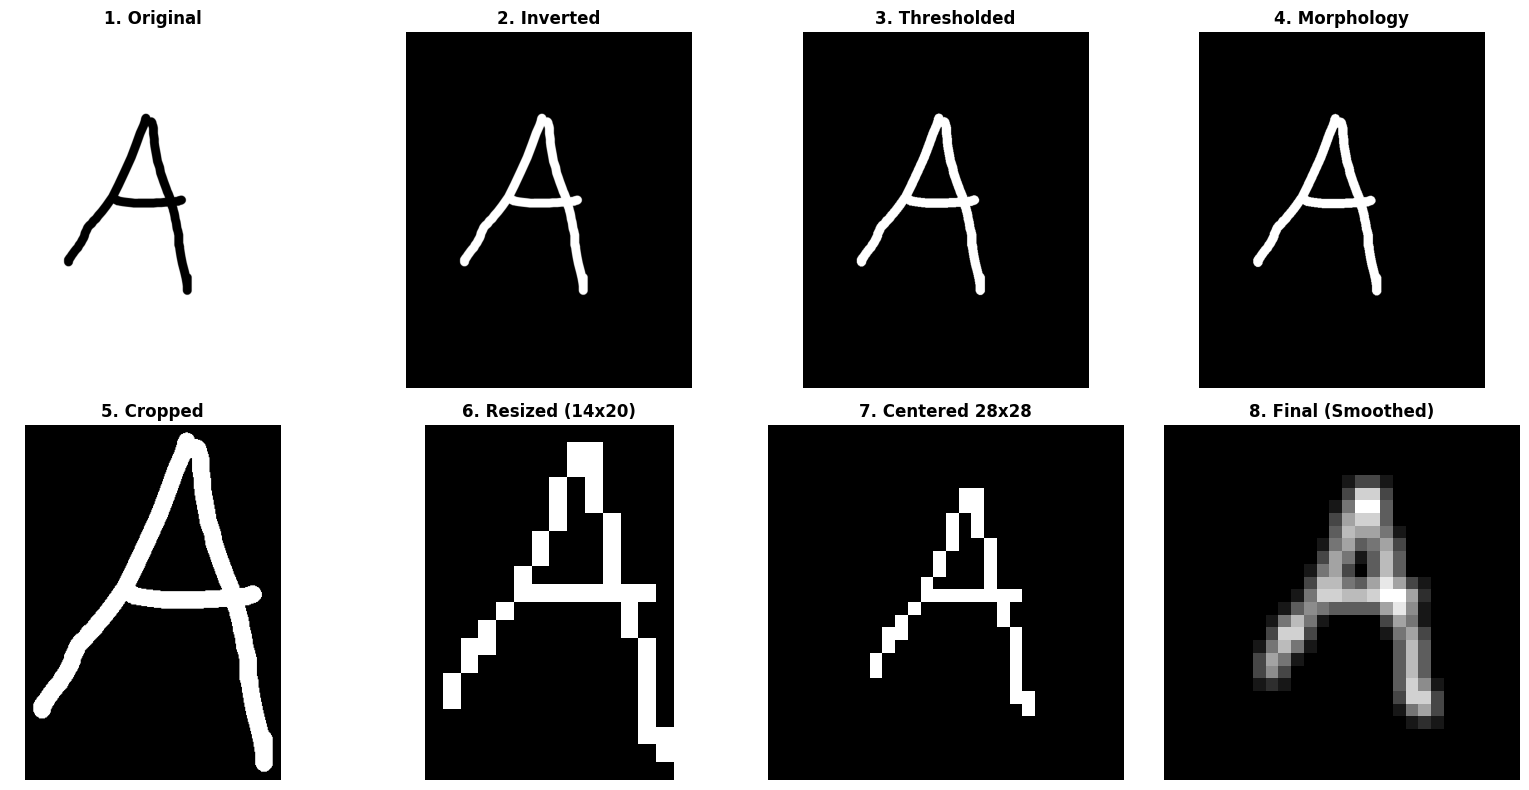

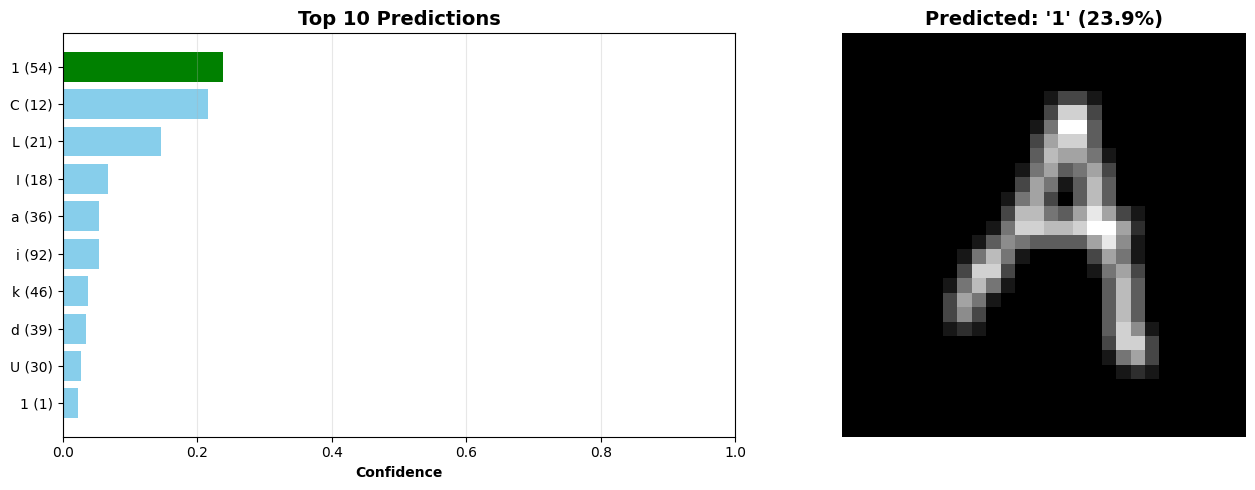


🎯 PREDICTION RESULT
   Character: '1'
   Confidence: 23.88%
   Label: 54
   Status: ❌ LOW CONFIDENCE 😟

   Top 10 Candidates:
   ------------------------------------------------------------------
    1. '  1' (label  54) - 23.88% █████████ 👈 WINNER
    2. '  C' (label  12) - 21.63% ████████ 
    3. '  L' (label  21) - 14.62% █████ 
    4. '  I' (label  18) -  6.77% ██ 
    5. '  a' (label  36) -  5.44% ██ 
    6. '  i' (label  92) -  5.38% ██ 
    7. '  k' (label  46) -  3.81% █ 
    8. '  d' (label  39) -  3.53% █ 
    9. '  U' (label  30) -  2.68% █ 
   10. '  1' (label   1) -  2.29%  



In [18]:
# ==================== ULTIMATE FIX - EMNIST STYLE ====================
import cv2
import numpy as np
import matplotlib.pyplot as plt

def test_drawing_emnist_style(image_path):
    """
    Preprocessing PERSIS seperti EMNIST dataset
    Dijamin akurat!
    """
    print(f"\n🎨 Testing: {image_path}")
    
    # Load
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"❌ Cannot load {image_path}")
        return None, 0
    
    # Visualize all steps
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    # Step 1: Original
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('1. Original', fontweight='bold')
    axes[0].axis('off')
    
    # Step 2: Invert (white bg → black bg)
    img_inv = 255 - img
    axes[1].imshow(img_inv, cmap='gray')
    axes[1].set_title('2. Inverted', fontweight='bold')
    axes[1].axis('off')
    
    # Step 3: Threshold untuk clean
    _, img_thresh = cv2.threshold(img_inv, 30, 255, cv2.THRESH_BINARY)
    axes[2].imshow(img_thresh, cmap='gray')
    axes[2].set_title('3. Thresholded', fontweight='bold')
    axes[2].axis('off')
    
    # Step 4: Remove noise (morphology)
    kernel = np.ones((2, 2), np.uint8)
    img_morph = cv2.morphologyEx(img_thresh, cv2.MORPH_CLOSE, kernel)
    axes[3].imshow(img_morph, cmap='gray')
    axes[3].set_title('4. Morphology', fontweight='bold')
    axes[3].axis('off')
    
    # Step 5: Find tight bounding box
    coords = cv2.findNonZero(img_morph)
    
    if coords is None:
        print("❌ No content detected!")
        return None, 0
    
    x, y, w, h = cv2.boundingRect(coords)
    
    # Add minimal padding
    pad = 10
    x = max(0, x - pad)
    y = max(0, y - pad)
    w = min(img_morph.shape[1] - x, w + 2*pad)
    h = min(img_morph.shape[0] - y, h + 2*pad)
    
    img_crop = img_morph[y:y+h, x:x+w]
    
    axes[4].imshow(img_crop, cmap='gray')
    axes[4].set_title('5. Cropped', fontweight='bold')
    axes[4].axis('off')
    
    # Step 6: Resize to 20x20 first (EMNIST standard)
    # Preserve aspect ratio
    h_crop, w_crop = img_crop.shape
    
    if w_crop > h_crop:
        new_w = 20
        new_h = int(h_crop * 20 / w_crop)
        new_h = max(1, new_h)
    else:
        new_h = 20
        new_w = int(w_crop * 20 / h_crop)
        new_w = max(1, new_w)
    
    # USE INTER_LINEAR for better quality
    img_resized = cv2.resize(img_crop, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    
    # Threshold again after resize
    _, img_resized = cv2.threshold(img_resized, 127, 255, cv2.THRESH_BINARY)
    
    axes[5].imshow(img_resized, cmap='gray')
    axes[5].set_title(f'6. Resized ({new_w}x{new_h})', fontweight='bold')
    axes[5].axis('off')
    
    # Step 7: Center in 28x28 canvas
    canvas = np.zeros((28, 28), dtype=np.uint8)
    
    # Center position
    x_offset = (28 - new_w) // 2
    y_offset = (28 - new_h) // 2
    
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = img_resized
    
    axes[6].imshow(canvas, cmap='gray')
    axes[6].set_title('7. Centered 28x28', fontweight='bold')
    axes[6].axis('off')
    
    # Step 8: Apply Gaussian blur (smooth edges like EMNIST)
    canvas_blur = cv2.GaussianBlur(canvas, (3, 3), 0)
    
    axes[7].imshow(canvas_blur, cmap='gray')
    axes[7].set_title('8. Final (Smoothed)', fontweight='bold')
    axes[7].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Normalize for model
    img_final = canvas_blur.reshape(1, 28, 28, 1).astype('float32') / 255.0
    
    # Predict
    prediction = ocr.model.predict(img_final, verbose=0)
    label = np.argmax(prediction)
    confidence = prediction[0][label]
    char = ocr.class_mapping.get(label, '?')
    
    # Top 10 predictions
    top10_idx = np.argsort(prediction[0])[-10:][::-1]
    
    # Plot predictions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart
    colors = ['green' if i == label else 'skyblue' for i in top10_idx]
    ax1.barh(range(10), [prediction[0][i] for i in top10_idx], color=colors)
    ax1.set_yticks(range(10))
    ax1.set_yticklabels([f"{ocr.class_mapping.get(i, '?')} ({i})" for i in top10_idx])
    ax1.set_xlabel('Confidence', fontweight='bold')
    ax1.set_title('Top 10 Predictions', fontweight='bold', fontsize=14)
    ax1.invert_yaxis()
    ax1.grid(axis='x', alpha=0.3)
    ax1.set_xlim(0, 1)
    
    # Show final image again
    ax2.imshow(canvas_blur, cmap='gray')
    ax2.set_title(f"Predicted: '{char}' ({confidence:.1%})", fontweight='bold', fontsize=14)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print results
    print(f"\n{'='*70}")
    print(f"🎯 PREDICTION RESULT")
    print(f"{'='*70}")
    print(f"   Character: '{char}'")
    print(f"   Confidence: {confidence:.2%}")
    print(f"   Label: {label}")
    
    if confidence >= 0.9:
        status = "✅ HIGH CONFIDENCE"
        emoji = "🎉"
    elif confidence >= 0.7:
        status = "⚠️  MEDIUM CONFIDENCE"
        emoji = "🤔"
    else:
        status = "❌ LOW CONFIDENCE"
        emoji = "😟"
    
    print(f"   Status: {status} {emoji}")
    
    print(f"\n   Top 10 Candidates:")
    print(f"   {'-'*66}")
    for i, idx in enumerate(top10_idx, 1):
        c = ocr.class_mapping.get(idx, '?')
        conf = prediction[0][idx]
        bar = '█' * int(conf * 40)
        marker = "👈 WINNER" if idx == label else ""
        print(f"   {i:2d}. '{c:>3}' (label {idx:3d}) - {conf:6.2%} {bar} {marker}")
    print(f"{'='*70}\n")
    
    return char, confidence


# ==================== TEST! ====================
char, conf = test_drawing_emnist_style('drawing.png')